In [1]:
import sys
sys.path.append('..')
from dhg import Hypergraph
from hypgs.models.hsn_pyg import HSN
from hypgs.utils.data import HGDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.data import random_split
from pytorch_lightning.loggers import TensorBoardLogger
from hypgs import DATA_DIR
import anndata
import os
import torch
import numpy as np
import phate
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import scanpy as sc
from sklearn.neighbors import kneighbors_graph
import random 
from torch_geometric.utils.convert import from_networkx


In [2]:
data_path = os.path.join(DATA_DIR, 'spatial_data', 'A23-290-CP_anndata.h5ad')
cell_data = anndata.read_h5ad(data_path)
print(cell_data)

AnnData object with n_obs × n_vars = 21331 × 16662
    obsm: 'X_spatial', 'spatial'


In [3]:
data_path_diseased = os.path.join(DATA_DIR, 'spatial_data', 'YA-7-CP_anndata.h5ad')
cell_data_diseased = anndata.read_h5ad(data_path_diseased)
print(cell_data_diseased)

AnnData object with n_obs × n_vars = 58459 × 24931
    obsm: 'X_spatial', 'spatial'


In [4]:
print(cell_data.var_names)
# CD45 is an immune gene marker
cd45_expression = cell_data[:, cell_data.var_names == 'PTPRC']

# This will give you a vector/array of CD45 expression values for all observations
print(cd45_expression)

Index(['HNRNPA3P13', 'CDH13', 'MS4A18', 'LINC01515', 'LARP4B-DT', 'RPS3AP51',
       'FBXW8', 'PPIAP7', 'DUSP5-DT', 'SLC6A9',
       ...
       'RPSAP61', 'PAX3', 'TDRD12', 'WHAMMP2', 'DNAH17-AS1', 'LINC01276',
       'BIK', 'KCNQ5', 'RPL12P17', 'IL33'],
      dtype='object', length=16662)
View of AnnData object with n_obs × n_vars = 21331 × 1
    obsm: 'X_spatial', 'spatial'


In [5]:
print(len(cell_data.var_names))

shared_elements = cell_data.var_names.intersection(cell_data_diseased.var_names)
print(shared_elements)


16662
Index(['HNRNPA3P13', 'CDH13', 'MS4A18', 'LINC01515', 'LARP4B-DT', 'RPS3AP51',
       'FBXW8', 'PPIAP7', 'DUSP5-DT', 'SLC6A9',
       ...
       'TPRXL', 'RPSAP61', 'PAX3', 'TDRD12', 'WHAMMP2', 'DNAH17-AS1',
       'LINC01276', 'BIK', 'RPL12P17', 'IL33'],
      dtype='object', length=15987)


In [6]:
cell_data = cell_data[:, cell_data.var_names.isin(shared_elements)]
cell_data_diseased = cell_data_diseased[:, cell_data_diseased.var_names.isin(shared_elements)]

print(cell_data)
print(cell_data_diseased)


View of AnnData object with n_obs × n_vars = 21331 × 15987
    obsm: 'X_spatial', 'spatial'
View of AnnData object with n_obs × n_vars = 58459 × 15987
    obsm: 'X_spatial', 'spatial'


In [4]:
cd45_expression.X

<21331x1 sparse matrix of type '<class 'numpy.float32'>'
	with 43 stored elements in Compressed Sparse Row format>

In [5]:
print(np.all(cell_data.obsm['X_spatial'] == cell_data.obsm['spatial']))
print(cell_data.obsm['spatial'].shape)


True
(21331, 2)


In [6]:
print(cell_data.X.shape)
print(type(cell_data.X))

(21331, 16662)
<class 'scipy.sparse._csr.csr_matrix'>


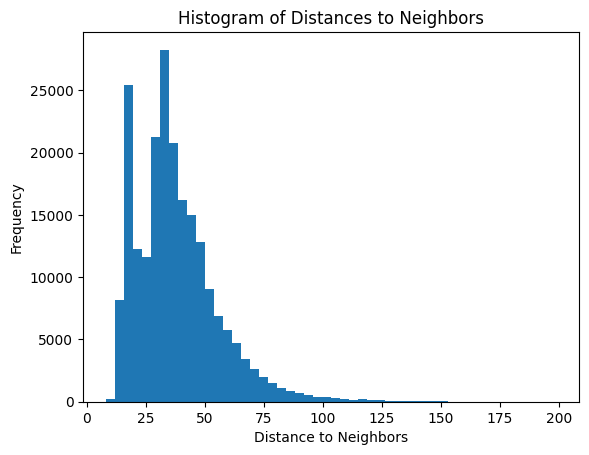

In [6]:
# Assuming 'X_spatial_data' is the actual 2D spatial data
X_spatial_data = cell_data.obsm['X_spatial']

# Construct KNN graph
n_neighbors = 10  # Number of neighbors for KNN
nn = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='euclidean')  # Add 1 to exclude self-loops
nn.fit(X_spatial_data)
distances, indices = nn.kneighbors(X_spatial_data)

# Exclude self-loops (the first neighbor is the point itself)
indices = indices[:, 1:]
distances = distances[:, 1:]

# Flatten distances for histogram
distances = distances.flatten()

# Plot histogram of distances
plt.hist(distances, bins=50)
plt.xlabel('Distance to Neighbors')
plt.ylabel('Frequency')
plt.title('Histogram of Distances to Neighbors')
plt.show()


In [7]:
# Define epsilon
epsilon = 30  # decide this based off the histogram

# Find pairs of points within epsilon distance
dist_matrix = euclidean_distances(X_spatial_data)
adj_matrix = (dist_matrix < epsilon).astype(int)

np.fill_diagonal(adj_matrix, 0)  # Ensure no self-loops

# Construct graph based on adjacency matrix
graph = nx.from_numpy_array(adj_matrix)

# nx.draw(graph, pos=X_spatial_data, node_size=10)
# plt.show()



In [9]:
# Assuming 'cell_data' is your AnnData object with sparse matrix 'X'
X_sparse = cell_data.X  # Extract the sparse matrix

# Convert the sparse matrix to a dense matrix
X_dense = X_sparse.toarray()

# Run PHATE on the dense matrix
phate_operator = phate.PHATE(n_components=10)
phate_result = phate_operator.fit_transform(X_dense)

# 'phate_result' now contains the PHATE embedding of your data
print(phate_result.shape)  # Shape of the resulting embedding

Calculating PHATE...
  Running PHATE on 21331 observations and 16662 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 57.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 69.66 seconds.
    Calculating affinities...
    Calculated affinities in 11.59 seconds.
  Calculated graph and diffusion operator in 138.90 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.45 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.87 seconds.
  Calculated landmark operator in 10.34 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 3.72 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.86 seconds.
  Calculating metric MDS...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 199.01 seconds.
Calculated PHATE in 352.85 seconds.
(21331, 10)


In [10]:
K=10
sparseA = kneighbors_graph(cell_data.obsm['spatial'], K, mode='connectivity', include_self=False)
A = sparseA.todense()
G = nx.from_numpy_array(A)

In [9]:
from torch_geometric.utils.convert import from_networkx
data = from_networkx(G)
data.x = torch.tensor(phate_result)
original_dataset = [data]
to_hg_func = lambda g: Hypergraph.from_graph_kHop(g, 1)
dataset = HGDataset(original_dataset, to_hg_func)

NameError: name 'G' is not defined

In [7]:
from importlib import reload
from hypgs.models.hsn_pyg import HSN
import hypgs
# Reload the module
#reload(hypgs.models.hsn_pyg)

# Now re-import the class
from hypgs.models.hsn_pyg import HSN

In [13]:
model = HSN(in_channels=10, 
              hidden_channels=16,
              out_channels = 1, 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              layout=['hsm'], 
              normalize='right', 
              pooling='max',
              task = 'node_representation'
        )

In [21]:
node_feat, edge_feat = model(dataset[0].x.float(), dataset[0].edge_index, hyperedge_attr = dataset[0].edge_attr)

In [32]:
edge_feat

tensor([[-0.1555],
        [-0.5940],
        [-0.1192],
        ...,
        [ 0.9134],
        [-0.0801],
        [-0.4296]], grad_fn=<AddmmBackward0>)

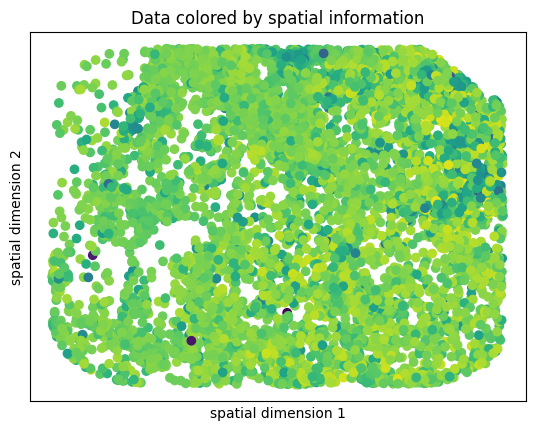

In [22]:
n_points = 8000

plt.scatter(cell_data.obsm['spatial'][:,0][:n_points], 
            cell_data.obsm['spatial'][:,1][:n_points], 
            c = node_feat[:n_points].detach().numpy())
plt.xlabel('spatial dimension 1')
plt.ylabel('spatial dimension 2')
plt.xticks([])
plt.yticks([])
plt.title('Data colored by full gene information')
plt.show()

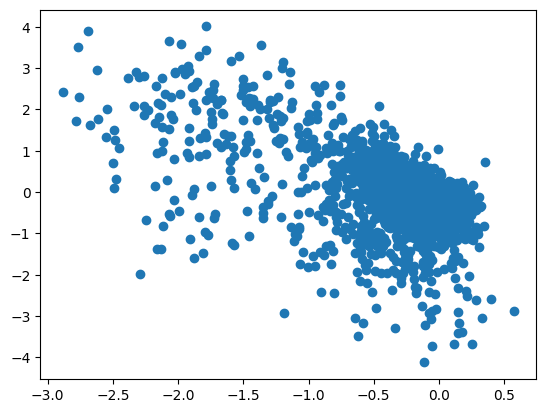

In [63]:
n_points = 6000
plt.scatter(edge_feat[:,0][:n_points].detach().numpy(), edge_feat[:,1][:n_points].detach().numpy())
plt.show()

In [24]:
cd45_expression = cell_data[:, cell_data.var_names == 'PTPRC']
node_features = cd45_expression.X.toarray()

print(node_features.shape)

(21331, 1)


In [8]:
def get_hyperedge_reps(model, cell_data, features='full_seq_phate'):
    K=10
    sparseA = kneighbors_graph(cell_data.obsm['spatial'], K, mode='connectivity', include_self=False)
    A = sparseA.todense()
    G = nx.from_numpy_array(A)

    if features == 'full_seq_phate':
        X_sparse = cell_data.X  # Extract the sparse matrix
        # Convert the sparse matrix to a dense matrix
        X_dense = X_sparse.toarray()
        # Run PHATE on the dense matrix
        phate_operator = phate.PHATE(n_components=10)
        phate_result = phate_operator.fit_transform(X_dense)
        node_features = phate_result
    elif features == 'cd45':
        cd45_expression = cell_data[:, cell_data.var_names == 'PTPRC']
        node_features = cd45_expression.X.toarray()
    elif features == 'rand_dirac':
        n_feat = 10
        n_cells = cell_data.X.shape[0]
        n = 100  # Change this value to the number of 1s you want in each column
        node_features = torch.zeros(n_cells, n_feat)

        for j in range(n_feat):
            indices = random.sample(range(n_cells), n)
            for index in indices:
                node_features[index][j] = 1
    else:
        node_features = cell_data.X.toarray()

    data = from_networkx(G)
    data.x = torch.tensor(node_features)
    original_dataset = [data]
    to_hg_func = lambda g: Hypergraph.from_graph_kHop(g, 1)
    dataset = HGDataset(original_dataset, to_hg_func)

    node_feat, edge_feat = model(dataset[0].x.float(), dataset[0].edge_index, hyperedge_attr = dataset[0].edge_attr)

    return edge_feat 

    # edge_feat_phate_op = phate.PHATE()
    # edge_phate = edge_feat_phate_op.fit_transform(edge_feat.detach().numpy())

    # n_points = 8000
    # plt.scatter(edge_phate[:, 0][:n_points], edge_phate[:,1][:n_points])
    # plt.title(f"hyperedge representations from {features}")
    # plt.xlabel('PHATE 1')
    # plt.ylabel('PHATE 2')
    # plt.xticks([])
    # plt.yticks([])
    # plt.show()

    # return edge_feat

In [15]:
# compare diseased and healthy patient samples using cd45 expression
model = HSN(in_channels=1, 
              hidden_channels=16,
              out_channels = 10, 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              layout=['hsm'], 
              normalize='right', 
              pooling='max',
              task = 'node_representation'
        )

healthy = get_hyperedge_reps(model, cell_data, features='cd45')
diseased = get_hyperedge_reps(model, cell_data_diseased, features='cd45')


Converting to hypergraph data: 100%|██████████| 1/1 [02:10<00:00, 130.05s/it]


In [9]:
import torch

# Concatenate the tensors
combined_tensor = torch.cat((healthy, diseased), dim=0)

# Create a tensor of 1s and 0s
labels = torch.cat((torch.zeros(healthy.shape[0]), torch.ones(diseased.shape[0])), dim=0)

# Print the combined tensor and labels
print(combined_tensor.shape)
print(labels)


NameError: name 'healthy' is not defined

In [10]:
import torch
from torch.utils.data import TensorDataset, random_split
import phate
import matplotlib.pyplot as plt

# Convert combined_tensor and labels to TensorDataset
dataset = TensorDataset(combined_tensor, labels)

# Randomly split the dataset into train and test sets
train_dataset, _ = random_split(dataset, [8000, len(dataset) - 8000])

# Get the sampled rows and labels
sampled_rows, sampled_labels = train_dataset[:]

# Convert the sampled rows to a numpy array
sampled_rows_np = sampled_rows.detach().numpy()

# Run PHATE on the sampled rows
phate_operator = phate.PHATE(n_components=2)
phate_result = phate_operator.fit_transform(sampled_rows_np)

# Plot the PHATE embedding and color each point by its label
phate_results_healthy = phate_result[sampled_labels == 0]
phate_results_diseased = phate_result[sampled_labels == 1]
plt.scatter(phate_results_healthy[:, 0], phate_results_healthy[:, 1], label='Healthy')
plt.scatter(phate_results_diseased[:, 0], phate_results_diseased[:, 1], label='Diseased')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.title('PHATE Visualization of Hyperedge Representations')
plt.legend()

plt.show()


NameError: name 'combined_tensor' is not defined

In [11]:
# compare diseased and healthy patient samples using full_seq_phate
model = HSN(in_channels=10, 
              hidden_channels=16,
              out_channels = 10, 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              layout=['hsm'], 
              normalize='right', 
              pooling='max',
              task = 'node_representation'
        )

healthy = get_hyperedge_reps(model, cell_data, features='full_seq_phate')
diseased = get_hyperedge_reps(model, cell_data_diseased, features='full_seq_phate')


Calculating PHATE...
  Running PHATE on 21331 observations and 15987 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 14.56 seconds.
    Calculating KNN search...
    Calculated KNN search in 74.98 seconds.
    Calculating affinities...
    Calculated affinities in 11.39 seconds.
  Calculated graph and diffusion operator in 100.97 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.41 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.43 seconds.
  Calculated landmark operator in 8.85 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 3.60 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.86 seconds.
  Calculating metric MDS...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 195.72 seconds.
Calculated PHATE in 310.02 seconds.


Converting to hypergraph data: 100%|██████████| 1/1 [00:27<00:00, 27.84s/it]


Calculating PHATE...
  Running PHATE on 58459 observations and 15987 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 38.43 seconds.
    Calculating KNN search...
    Calculated KNN search in 153.99 seconds.
    Calculating affinities...
    Calculated affinities in 46.26 seconds.
  Calculated graph and diffusion operator in 238.79 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 8.65 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.64 seconds.
  Calculated landmark operator in 18.85 seconds.
  Calculating optimal t...
    Automatically selected t = 36
  Calculated optimal t in 3.68 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.02 seconds.
  Calculating metric MDS...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 214.19 seconds.
Calculated PHATE in 476.54 seconds.


Converting to hypergraph data: 100%|██████████| 1/1 [02:08<00:00, 128.83s/it]


In [12]:
import torch

# Concatenate the tensors
combined_tensor = torch.cat((healthy, diseased), dim=0)

# Create a tensor of 1s and 0s
labels = torch.cat((torch.zeros(healthy.shape[0]), torch.ones(diseased.shape[0])), dim=0)

# Print the combined tensor and labels
print(combined_tensor.shape)
print(labels)


torch.Size([79615, 10])
tensor([0., 0., 0.,  ..., 1., 1., 1.])


Calculating PHATE...
  Running PHATE on 2000 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.08 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.11 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 9.00 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.44 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.75 seconds.
Calculated PHATE in 15.32 seconds.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


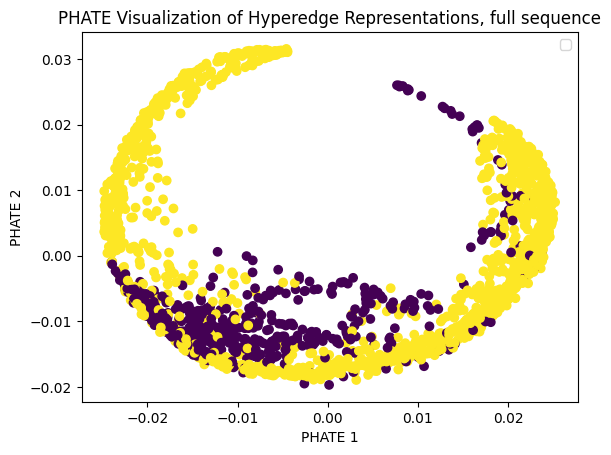

In [17]:
import torch
from torch.utils.data import TensorDataset, random_split
import phate
import matplotlib.pyplot as plt

# Convert combined_tensor and labels to TensorDataset
dataset = TensorDataset(combined_tensor, labels)

# Randomly split the dataset into train and test sets
n_points = 2000
train_dataset, _ = random_split(dataset, [n_points, len(dataset) - n_points])

# Get the sampled rows and labels
sampled_rows, sampled_labels = train_dataset[:]

# Convert the sampled rows to a numpy array
sampled_rows_np = sampled_rows.detach().numpy()

# Run PHATE on the sampled rows
phate_operator = phate.PHATE(n_components=2)
phate_result = phate_operator.fit_transform(sampled_rows_np)

# Plot the PHATE embedding and color each point by its label
plt.scatter(phate_result[:, 0], phate_result[:, 1], c = sampled_labels)
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.title('PHATE Visualization of Hyperedge Representations, full sequence')
plt.legend()

plt.show()

# # Plot the PHATE embedding and color each point by its label
# phate_results_healthy = phate_result[sampled_labels == 0]
# phate_results_diseased = phate_result[sampled_labels == 1]
# plt.scatter(phate_results_healthy[:, 0], phate_results_healthy[:, 1], label='Healthy')
# plt.scatter(phate_results_diseased[:, 0], phate_results_diseased[:, 1], label='Diseased')
# plt.xlabel('PHATE 1')
# plt.ylabel('PHATE 2')
# plt.title('PHATE Visualization of Hyperedge Representations')
# plt.legend()

# plt.show()


In [20]:
# i need to see which one of these markers exist in the keys 

print(shared_elements)

Index(['HNRNPA3P13', 'CDH13', 'MS4A18', 'LINC01515', 'LARP4B-DT', 'RPS3AP51',
       'FBXW8', 'PPIAP7', 'DUSP5-DT', 'SLC6A9',
       ...
       'TPRXL', 'RPSAP61', 'PAX3', 'TDRD12', 'WHAMMP2', 'DNAH17-AS1',
       'LINC01276', 'BIK', 'RPL12P17', 'IL33'],
      dtype='object', length=15987)


In [11]:
# check if 'CDH1' is in shared elements

# epithelial cell marker: CDh1, 
print('CDH1' in shared_elements)
print('KRT8' in shared_elements)
print('KRT18' in shared_elements)
print('EpCAM' in shared_elements)
epithelial_cell_markers = ['CDH1', 'KRT8', 'KRT18']
# CDH1 is a tumor suppressor gene, associated with hereditary diffuse gastric cancer
# KRT8 is a keratin gene, normally reacting wth secretory epithelia in normal cells. Useful in detecting breast carcinoma
# KRT18 is a keratin gene, normally expressed in singla layer epithelial tissues of the body


print('checking pericyte markers')
print('PDGFRB' in shared_elements)
print('ACTA2' in shared_elements)
print('PDGFRA' in shared_elements)
print('NG2' in shared_elements)
print('RGS5' in shared_elements)
pericyte_markers = ['PDGFRB', 'ACTA2', 'PDGFRA', 'RGS5']
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9199463/
#PDGFRB is known pericyte marker, encodes for platelet-derived growth factor receptor beta
#ACTA2 is known pericyte marker, encodes for alpha smooth muscle actin. Also expressed in smooth muscle
#PDGFRA encodes for platelet-derived growth factor receptor alpha, but also found in fibroblasts 
#RGS5 encodes for regulator of G protein signaling 5, involved in vascular remodeling and angiogenesis. human heart


print('checking immune markers')
print('CD45' in shared_elements)
print('CD68' in shared_elements)
print('CD3' in shared_elements)
print('CD4' in shared_elements)
print('CD8' in shared_elements)
print('CD20' in shared_elements)
print('CD163' in shared_elements)
print('CD11b' in shared_elements)
immune_markers = ['CD68', 'CD4', 'CD163']
# https://www.nature.com/articles/labinvest2016116
# https://en.wikipedia.org/wiki/CD4
# https://en.wikipedia.org/wiki/CD163
# CD68 encodes for a glycoprotein found in lysosomes, heavily expressed in macrophages
# CD4 encodes for a glycoprotein found on the surface of T helper cells, binds to MHC class II molecules
# CD163 encodes for a scavenger receptor found on the surface of monocytes and macrophages, binds to hemoglobin-haptoglobin complexes
total_markers = epithelial_cell_markers + pericyte_markers + immune_markers
# check that all total markers are in shared_elements
print('asserting correctness of assignment')
print(all(elem in shared_elements for elem in total_markers))

True
True
True
False
checking pericyte markers
True
True
True
False
True
checking immune markers
False
True
False
True
False
False
True
False
asserting correctness of assignment
True


In [12]:
# create cell_data with only the total markers
cell_data_total_markers = cell_data[:, cell_data.var_names.isin(total_markers)]
cell_data_diseased_total_markers = cell_data_diseased[:, cell_data_diseased.var_names.isin(total_markers)]
print(cell_data_total_markers)
print(cell_data_diseased_total_markers)

View of AnnData object with n_obs × n_vars = 21331 × 10
    obsm: 'X_spatial', 'spatial'
View of AnnData object with n_obs × n_vars = 58459 × 10
    obsm: 'X_spatial', 'spatial'


In [17]:
model = HSN(in_channels=10, 
              hidden_channels=16,
              out_channels = 10, 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              layout=['hsm'], 
              normalize='right', 
              pooling='max',
              task = 'node_representation'
        )

healthy = get_hyperedge_reps(model, cell_data_total_markers, features='hand_picked_markers')
diseased = get_hyperedge_reps(model, cell_data_diseased_total_markers, features='hand_picked_markers')

Converting to hypergraph data: 100%|██████████| 1/1 [02:07<00:00, 127.99s/it]


Calculating PHATE...
  Running PHATE on 79615 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 53.86 seconds.
    Calculating affinities...
    Calculated affinities in 0.28 seconds.
  Calculated graph and diffusion operator in 54.20 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 8.39 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.73 seconds.
  Calculated landmark operator in 18.98 seconds.
  Calculating optimal t...
    Automatically selected t = 59
  Calculated optimal t in 3.76 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.51 seconds.
  Calculating metric MDS...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 104.20 seconds.
Calculated PHATE in 182.66 seconds.


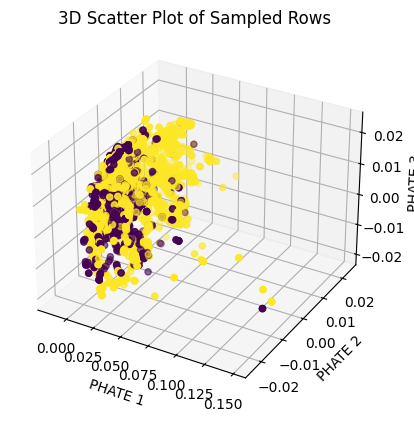

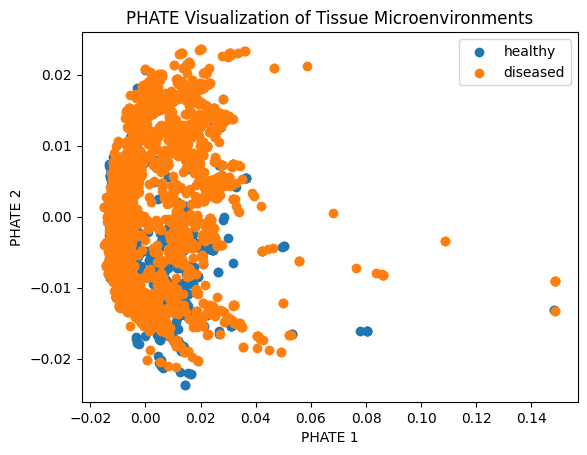

In [18]:
from mpl_toolkits.mplot3d import Axes3D
# Concatenate the tensors
combined_tensor = torch.cat((healthy, diseased), dim=0)
phate_operator = phate.PHATE(n_components=3)
phate_result = phate_operator.fit_transform(combined_tensor.detach().numpy())

# Create a tensor of 1s and 0s
labels = torch.cat((torch.zeros(healthy.shape[0]), torch.ones(diseased.shape[0])), dim=0)

# Convert combined_tensor and labels to TensorDataset
dataset = TensorDataset(torch.tensor(phate_result), labels)

n_points = 10000
# Randomly split the dataset into train and test sets
train_dataset, _ = random_split(dataset, [n_points, len(dataset) - n_points])

# Get the sampled rows and labels
sampled_rows, sampled_labels = train_dataset[:]

# Convert the sampled rows to a numpy array
sampled_rows_np = sampled_rows.detach().numpy()

# make a 3d scatter plot of sampled rows

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sampled_rows_np[:, 0], sampled_rows_np[:, 1], sampled_rows_np[:, 2], c=sampled_labels)

ax.set_xlabel('PHATE 1')
ax.set_ylabel('PHATE 2')
ax.set_zlabel('PHATE 3')
ax.set_title('3D Scatter Plot of Sampled Rows')

plt.show()


#plt.scatter(sampled_rows_np[:, 0], sampled_rows_np[:, 1], c = sampled_labels)
phate_results_healthy = sampled_rows_np[sampled_labels == 0]
phate_results_diseased = sampled_rows_np[sampled_labels == 1]
plt.scatter(phate_results_healthy[:, 0], phate_results_healthy[:, 1], label='Healthy')
plt.scatter(phate_results_diseased[:, 0], phate_results_diseased[:, 1], label='Diseased')


# # Plot the PHATE embedding and color each point by its label
# phate_results_healthy = phate_result[sampled_labels == 0]
# phate_results_diseased = phate_result[sampled_labels == 1]
# plt.scatter(phate_results_healthy[:, 0], phate_results_healthy[:, 1], label='Healthy')
# plt.scatter(phate_results_diseased[:, 0], phate_results_diseased[:, 1], label='Diseased')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.title('PHATE Visualization of Tissue Microenvironments')
plt.legend(['healthy', 'diseased'])

plt.show()


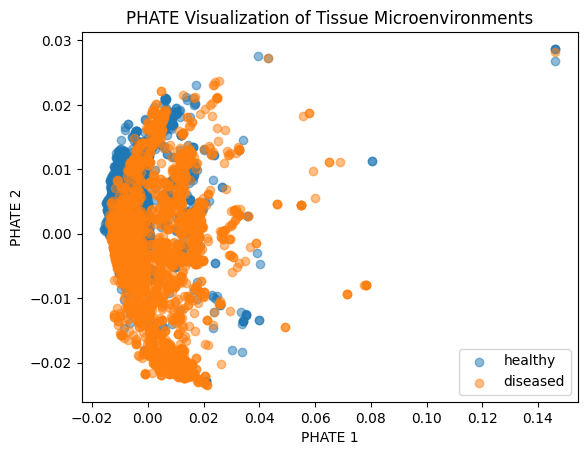

In [15]:
#plt.scatter(sampled_rows_np[:, 0], sampled_rows_np[:, 1], c = sampled_labels)
phate_results_healthy = sampled_rows_np[sampled_labels == 0]
phate_results_diseased = sampled_rows_np[sampled_labels == 1]
plt.scatter(phate_results_healthy[:, 0], phate_results_healthy[:, 1], label='Healthy', alpha=.5)
plt.scatter(phate_results_diseased[:, 0], phate_results_diseased[:, 1], label='Diseased', alpha=.5)


# # Plot the PHATE embedding and color each point by its label
# phate_results_healthy = phate_result[sampled_labels == 0]
# phate_results_diseased = phate_result[sampled_labels == 1]
# plt.scatter(phate_results_healthy[:, 0], phate_results_healthy[:, 1], label='Healthy')
# plt.scatter(phate_results_diseased[:, 0], phate_results_diseased[:, 1], label='Diseased')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.title('PHATE Visualization of Tissue Microenvironments')
plt.legend(['healthy', 'diseased'])

plt.show()

Calculating PHATE...
  Running PHATE on 8000 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.25 seconds.
    Calculating affinities...
    Calculated affinities in 0.08 seconds.
  Calculated graph and diffusion operator in 1.38 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.11 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.10 seconds.
  Calculated landmark operator in 9.97 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 3.75 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.20 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.55 seconds.
Calculated PHATE in 20.87 seconds.


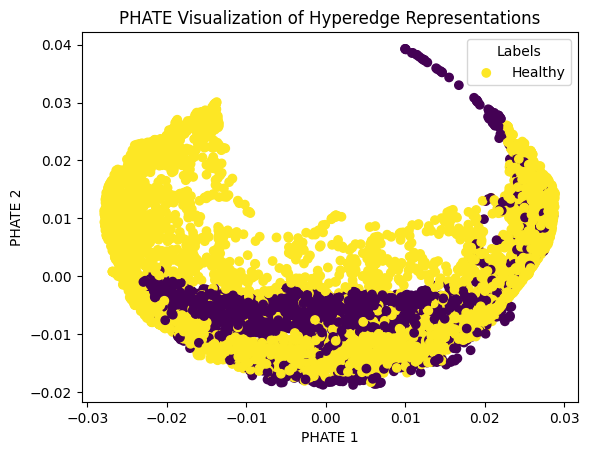

In [33]:
import torch
from torch.utils.data import TensorDataset, random_split
import phate
import matplotlib.pyplot as plt

# Convert combined_tensor and labels to TensorDataset
dataset = TensorDataset(combined_tensor, labels)

# Randomly split the dataset into train and test sets
train_dataset, _ = random_split(dataset, [8000, len(dataset) - 8000])

# Get the sampled rows and labels
sampled_rows, sampled_labels = train_dataset[:]

# Convert the sampled rows to a numpy array
sampled_rows_np = sampled_rows.detach().numpy()

# Run PHATE on the sampled rows
phate_operator = phate.PHATE(n_components=2)
phate_result = phate_operator.fit_transform(sampled_rows_np)

# Plot all points at once and assign a color to each label
plt.scatter(phate_result[:, 0], phate_result[:, 1], c=sampled_labels, cmap='viridis', label='Data Points')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.title('PHATE Visualization of Hyperedge Representations')

# Create a legend based on the unique labels
unique_labels = torch.unique(sampled_labels)
legend_labels = ['Healthy' if label == 0 else 'Diseased' for label in unique_labels]
plt.legend(legend_labels, title='Labels')

plt.show()

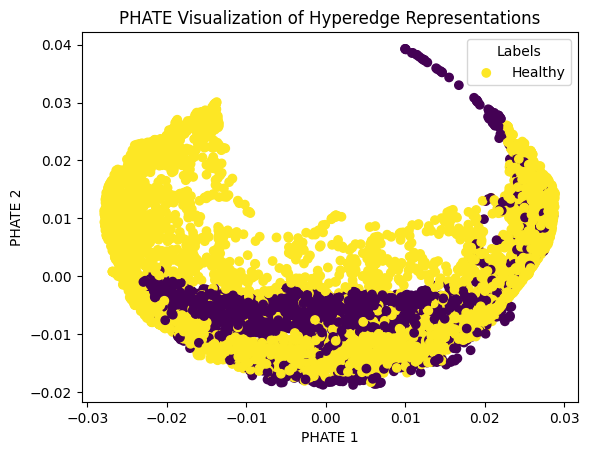

In [35]:
# Plot all points at once and assign a color to each label
plt.scatter(phate_result[:, 0], phate_result[:, 1], c=sampled_labels, label='Data Points')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.title('PHATE Visualization of Hyperedge Representations')

# Create a legend based on the unique labels
unique_labels = torch.unique(sampled_labels)
legend_labels = ['Healthy' , 'Diseased']
plt.legend(legend_labels, title='Labels')


Converting to hypergraph data: 100%|██████████| 1/1 [00:28<00:00, 28.90s/it]


Calculating PHATE...
  Running PHATE on 21213 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.41 seconds.
    Calculating affinities...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 71614 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 12.88 seconds.
  Calculated graph and diffusion operator in 14.60 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 7.91 seconds.
    Calculating KMeans...
    Calculated KMeans in 10.73 seconds.
  Calculated landmark operator in 19.53 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 2.88 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.09 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.60 seconds.
Calculated PHATE in 41.72 seconds.


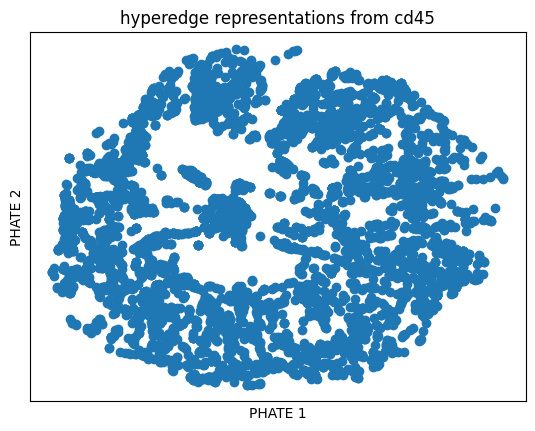

In [7]:
model = HSN(in_channels=1, 
              hidden_channels=16,
              out_channels = 10, 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              layout=['hsm'], 
              normalize='right', 
              pooling='max',
              task = 'node_representation'
        )

get_hyperedge_reps(model, cell_data, features='cd45')

Calculating PHATE...
  Running PHATE on 21331 observations and 16662 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 15.35 seconds.
    Calculating KNN search...
    Calculated KNN search in 66.82 seconds.
    Calculating affinities...
    Calculated affinities in 10.06 seconds.
  Calculated graph and diffusion operator in 92.28 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.32 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.09 seconds.
  Calculated landmark operator in 8.43 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 3.62 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.19 seconds.
  Calculating metric MDS...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 199.02 seconds.
Calculated PHATE in 304.55 seconds.
Calculating PHATE...
  Running PHATE on 21213 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 4.91 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 4.99 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.58 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.57 seconds.
  Calculated landmark operator in 8.11 seconds.
  Calculating optimal t...
    Automatically selected t = 41
  Calculated optimal t in 3.79 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.18 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.70 seconds.
Calculated PHATE in 22.79 seconds.


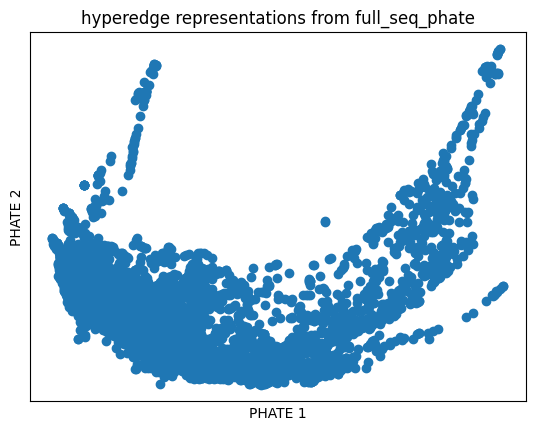

In [11]:
model = HSN(in_channels=10, 
              hidden_channels=16,
              out_channels = 10, 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              layout=['hsm'], 
              normalize='right', 
              pooling='max',
              task = 'node_representation'
        )

get_hyperedge_reps(model, cell_data, features='full_seq_phate')

/tmp/ipykernel_2240861/2978064971.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.x = torch.tensor(node_features)


Calculating PHATE...
  Running PHATE on 21213 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 6.98 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 7.07 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.62 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.98 seconds.
  Calculated landmark operator in 7.55 seconds.
  Calculating optimal t...
    Automatically selected t = 46
  Calculated optimal t in 3.75 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.34 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.58 seconds.
Calculated PHATE in 24.31 seconds.


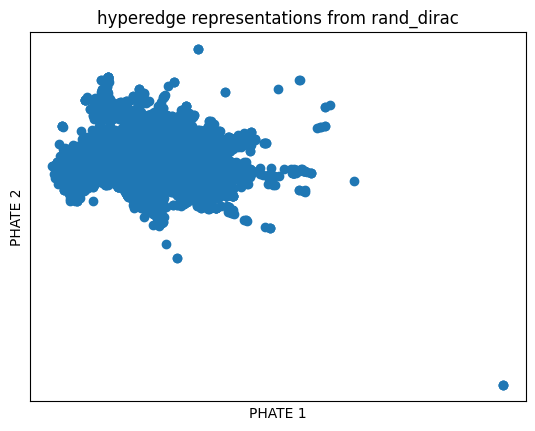

In [12]:
model = HSN(in_channels=10, 
              hidden_channels=16,
              out_channels = 10, 
              trainable_laziness = False,
              trainable_scales = False, 
              activation = None, # just get one layer of wavelet transform 
              fixed_weights=True, 
              layout=['hsm'], 
              normalize='right', 
              pooling='max',
              task = 'node_representation'
        )

get_hyperedge_reps(model, cell_data, features='rand_dirac')

In [ ]:
# scatter immune information 
print(cell_data.var_names)
# CD45 is an immune gene marker
cd45_expression = cell_data[:, cell_data.var_names == 'PTPRC']


# This will give you a vector/array of CD45 expression values for all observations
print(cd45_expression)

In [39]:
# Early stopping callback based on validation loss
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
logger = TensorBoardLogger("lightning_logs", name="my_model")

trainer = pl.Trainer(
    max_epochs=100,  # Adjust as necessary
    logger=logger,
    callbacks=[early_stopping_callback]
)

# Assuming you have defined train_loader and val_loader
trainer.fit(model, train_loader, val_loader)  # Corrected argument names
# Test the model
trainer.test(model, test_loader)

/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


NameError: name 'train_loader' is not defined

In [48]:
n_feat = 4
n_cells = 10
n = 3  # Change this value to the number of 1s you want in each column
node_features = torch.zeros(n_cells, n_feat)

for j in range(n_feat):
    indices = random.sample(range(n_cells), n)
    for index in indices:
        node_features[index][j] = 1

print(node_features)

tensor([[0., 0., 0., 1.],
        [0., 1., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 0.]])


In [46]:
node_features

tensor([[0., 1., 1., 1.],
        [1., 1., 1., 0.],
        [0., 1., 1., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [0., 1., 1., 1.],
        [1., 1., 0., 1.]])